# Домашнее задание. Нейросетевая классификация текстов

В этом домашнем задании вам предстоит самостоятельно решить задачу классификации текстов на основе семинарского кода. Мы будем использовать датасет [ag_news](https://paperswithcode.com/dataset/ag-news). Это датасет для классификации новостей на 4 темы: "World", "Sports", "Business", "Sci/Tech".

Установим модуль datasets, чтобы нам проще было работать с данными.

In [1]:
!pip install datasets

Импорт необходимых библиотек

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import string

import seaborn
seaborn.set(palette='summer')

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных
Для вашего удобства, мы привели код обработки датасета в ноутбуке. Ваша задача --- обучить модель, которая получит максимальное возможное качество на тестовой части.

In [5]:
# Загрузим датасет
dataset = datasets.load_dataset('ag_news')

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Dataset ag_news downloaded and prepared to /root/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Как и в семинаре, выполним следующие шаги:
* Составим словарь
* Создадим класс WordDataset
* Выделим обучающую и тестовую часть, создадим DataLoader-ы.

In [6]:
words = Counter()

for example in tqdm(dataset['train']['text']):
    # Приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = example.lower().translate(
        str.maketrans('', '', string.punctuation))

    for word in word_tokenize(prccessed_text):
        words[word] += 1


vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 25

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

  0%|          | 0/120000 [00:00<?, ?it/s]

Размер словаря: 11842


In [7]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation))
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
            ]
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "label": self.data[idx]['label']
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)

    


def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])

    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

In [8]:
train_dataset = WordDataset(dataset['train'])

np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['test'])), 5000)

eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 32
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Постановка задачи
Ваша задача -- получить максимальное возможное accuracy на `eval_dataloader`. Ниже приведена функция, которую вам необходимо запустить для обученной модели, чтобы вычислить качество её работы.

## Базовое решение

In [9]:
#Базовая модель
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [10]:
def evaluate(model, eval_dataloader) -> float:
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

In [11]:
# будем считать acc на тренировочной выборке
batch_size= 32

len_eval_dataloader = 150
current_idx = np.random.choice(np.arange(len(dataset['train'])), len(eval_dataset))
train_dataset_acc = WordDataset(dataset['train'].select(current_idx))
train_accuracy = DataLoader(train_dataset_acc, collate_fn=collate_fn_with_padding, shuffle=True, batch_size=batch_size)

In [12]:
def train_loop(model, optimizer, criterion, aggregation_type, num_epoch):
    eval_steps = len(train_dataloader) // 5

    losses = []
    acc = []
    acc_train = []

    print(f"Starting training for {aggregation_type}")

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                acc_train.append(evaluate(model, train_accuracy)) #Берем случайным образом 150 элементов тренировочной выборки
                acc.append(evaluate(model, eval_dataloader))
                model.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))
        
    return (losses, acc, acc_train)

In [73]:
num_epochs = 10
losses = {}
acc = {}
acc_train = {}


for aggregation_type in ["max", "mean"]:
    model = CharLM(hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    losses[aggregation_type], acc[aggregation_type], acc_train[aggregation_type] = train_loop(model, 
                                                                                              optimizer, 
                                                                                              criterion,
                                                                                              aggregation_type,
                                                                                              num_epochs)

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/3750 [00:00<?, ?it/s]

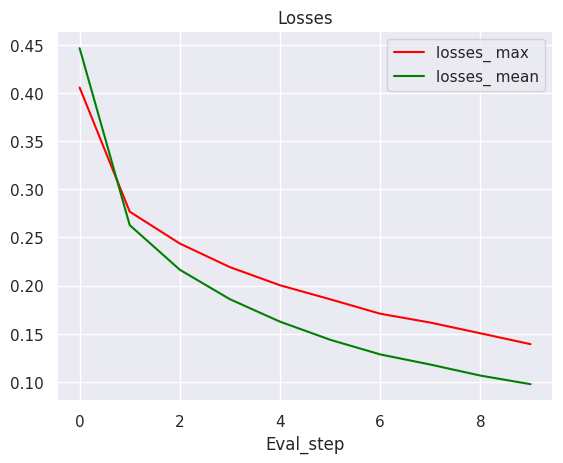

{'max': [0.40602915442784626,
  0.27683407020121814,
  0.24368075126608213,
  0.21911593215664227,
  0.2002609900643428,
  0.1856738263120254,
  0.17063906555101274,
  0.16142659440177182,
  0.15026643658416966,
  0.13896402550612888],
 'mean': [0.4469762457887332,
  0.2628274763877193,
  0.21639637876550358,
  0.18573748477001986,
  0.16236404303026697,
  0.14355496127518516,
  0.12828413912821562,
  0.11774611808266491,
  0.10624871592440953,
  0.09730724422546724]}

In [74]:
for (aggregation_type, color) in zip(["max", "mean"], ["r", "g"]):
    plt.plot(np.arange(len(losses[aggregation_type])), losses[aggregation_type], color=color, label=f"losses_ {aggregation_type}")

plt.title('Losses')
plt.xlabel("Eval_step")
plt.legend()
plt.show()
losses

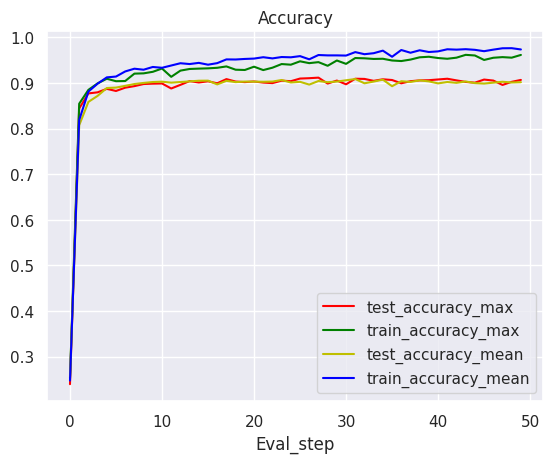

In [75]:
for (aggregation_type, color) in zip(["max", "mean"], [["r", "g"], ["y", "b"]]):
    plt.plot(np.arange(len(acc[aggregation_type])), acc[aggregation_type], color=color[0], label=f"test_accuracy_{aggregation_type}")
    plt.plot(np.arange(len(acc_train[aggregation_type])), acc_train[aggregation_type], color=color[1], label=f"train_accuracy_{aggregation_type}")

plt.title('Accuracy')
plt.xlabel("Eval_step")
plt.legend()
plt.show()

In [76]:
max(acc_train["max"]), max(acc_train["mean"]), max(acc["max"]), max(acc["mean"])

(0.9615999460220337,
 0.9761999845504761,
 0.9115999937057495,
 0.9085999727249146)

## Эксперименты

### 1) Реализуем GRU

In [19]:
class GRU_model(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [20]:
num_epochs = 10
losses = {}
acc = {}
acc_train = {}


for aggregation_type in ["max", "mean"]:
    model = GRU_model(hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    losses[aggregation_type], acc[aggregation_type], acc_train[aggregation_type] = train_loop(model, 
                                                                                              optimizer, 
                                                                                              criterion,
                                                                                              aggregation_type,
                                                                                              num_epochs)

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/3750 [00:00<?, ?it/s]

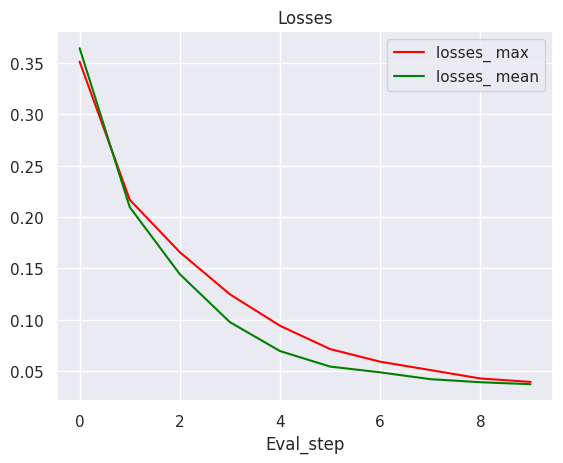

{'max': [0.3512165154228608,
  0.21688220643798511,
  0.16582338730643192,
  0.12484327738458911,
  0.0942452568740584,
  0.07156260627283094,
  0.05926253538948174,
  0.051159166579693556,
  0.0429469840354519,
  0.039600616214459296],
 'mean': [0.3643005909174681,
  0.20969563116108378,
  0.14441712153243522,
  0.09774654727739593,
  0.06963277353043668,
  0.05451798832778198,
  0.04891051240320861,
  0.04228794917037012,
  0.039296486177208136,
  0.03740038566030756]}

In [21]:
for (aggregation_type, color) in zip(["max", "mean"], ["r", "g"]):
    plt.plot(np.arange(len(losses[aggregation_type])), losses[aggregation_type], color=color, label=f"losses_ {aggregation_type}")

plt.title('Losses')
plt.xlabel("Eval_step")
plt.legend()
plt.show()
losses

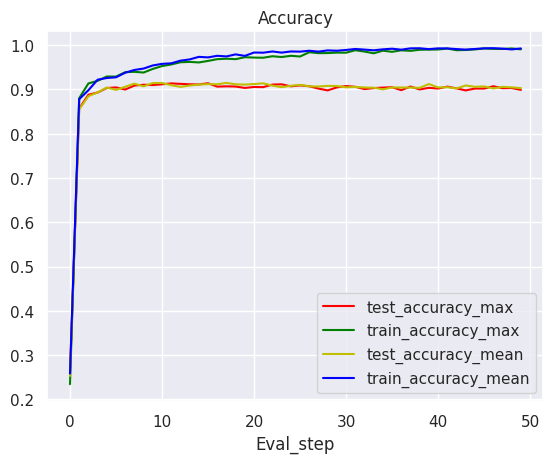

In [23]:
for (aggregation_type, color) in zip(["max", "mean"], [["r", "g"], ["y", "b"]]):
    plt.plot(np.arange(len(acc[aggregation_type])), acc[aggregation_type], color=color[0], label=f"test_accuracy_{aggregation_type}")
    plt.plot(np.arange(len(acc_train[aggregation_type])), acc_train[aggregation_type], color=color[1], label=f"train_accuracy_{aggregation_type}")

plt.title('Accuracy')
plt.xlabel("Eval_step")
plt.legend()
plt.show()

In [24]:
max(acc_train["max"]), max(acc_train["mean"]), max(acc["max"]), max(acc["mean"])

(0.9925999641418457,
 0.9932000041007996,
 0.9139999747276306,
 0.9147999882698059)

### 2) Увеличим кол-во hidden_dim и dropout_rate для базового решения

In [16]:
#изменим dropout_rate
class CharLM_version_1(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.3)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [17]:
num_epochs = 8
losses = {}
acc = {}
acc_train = {}


for aggregation_type in ["max", "mean"]:
    model = CharLM_version_1(hidden_dim=512, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    losses[aggregation_type], acc[aggregation_type], acc_train[aggregation_type] = train_loop(model, 
                                                                                              optimizer, 
                                                                                              criterion,
                                                                                              aggregation_type,
                                                                                              num_epochs)

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

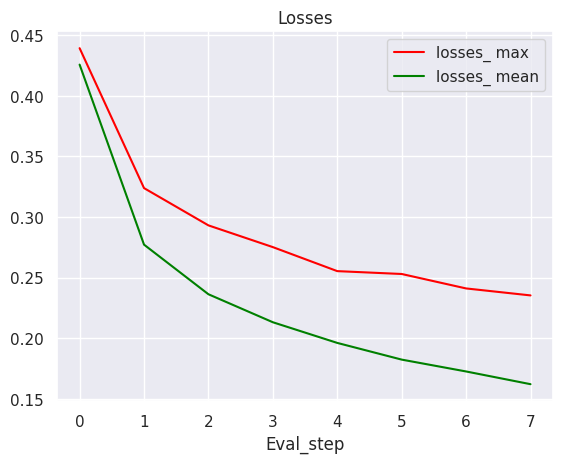

{'max': [0.4393206324060758,
  0.3238134933819373,
  0.2930435894936323,
  0.27509972575654584,
  0.25528137216418983,
  0.2529185007741054,
  0.24098859465519587,
  0.2352364272137483],
 'mean': [0.4257606116304795,
  0.2771456641028325,
  0.23618062150254845,
  0.21308014950727422,
  0.19601777753308416,
  0.18223898151579002,
  0.1724475965415438,
  0.1619522142102321]}

In [18]:
for (aggregation_type, color) in zip(["max", "mean"], ["r", "g"]):
    plt.plot(np.arange(len(losses[aggregation_type])), losses[aggregation_type], color=color, label=f"losses_ {aggregation_type}")

plt.title('Losses')
plt.xlabel("Eval_step")
plt.legend()
plt.show()
losses

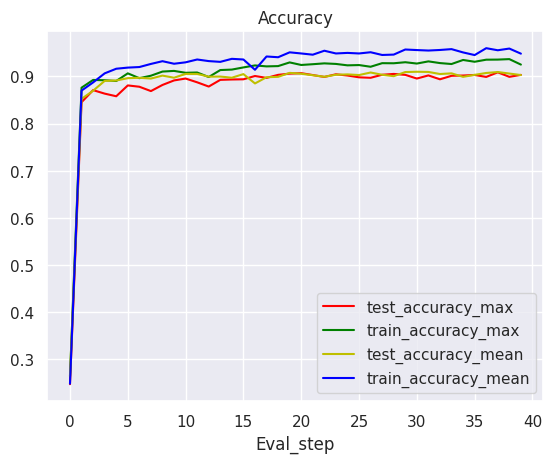

In [19]:
for (aggregation_type, color) in zip(["max", "mean"], [["r", "g"], ["y", "b"]]):
    plt.plot(np.arange(len(acc[aggregation_type])), acc[aggregation_type], color=color[0], label=f"test_accuracy_{aggregation_type}")
    plt.plot(np.arange(len(acc_train[aggregation_type])), acc_train[aggregation_type], color=color[1], label=f"train_accuracy_{aggregation_type}")

plt.title('Accuracy')
plt.xlabel("Eval_step")
plt.legend()
plt.show()

In [20]:
max(acc_train["max"]), max(acc_train["mean"]), max(acc["max"]), max(acc["mean"])

(0.9365999698638916,
 0.9598000049591064,
 0.9085999727249146,
 0.9097999930381775)

### 3) Попробуем применить для GRU_model:

In [13]:
class GRU_model_version_1(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.25)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [14]:
num_epochs = 8
losses = {}
acc = {}
acc_train = {}


for aggregation_type in ["max", "mean"]:
    model = GRU_model_version_1(hidden_dim=512, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    losses[aggregation_type], acc[aggregation_type], acc_train[aggregation_type] = train_loop(model, 
                                                                                              optimizer, 
                                                                                              criterion,
                                                                                              aggregation_type,
                                                                                              num_epochs)

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

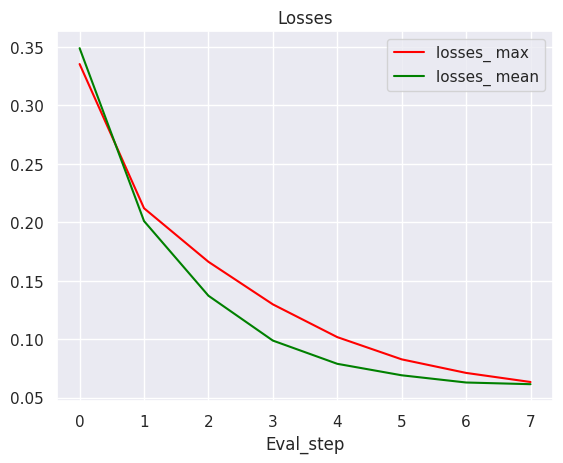

{'max': [0.33536869707504907,
  0.21195846344033878,
  0.16613190836807093,
  0.12971330592210095,
  0.10167670726493622,
  0.08265434377746812,
  0.07104420464100161,
  0.0632720891144049],
 'mean': [0.3489469940826297,
  0.2009914090866844,
  0.13709048493448645,
  0.09871176850069315,
  0.07883688947504852,
  0.06901158313104727,
  0.06283760425483731,
  0.061399595898754586]}

In [16]:
for (aggregation_type, color) in zip(["max", "mean"], ["r", "g"]):
    plt.plot(np.arange(len(losses[aggregation_type])), losses[aggregation_type], color=color, label=f"losses_ {aggregation_type}")

plt.title('Losses')
plt.xlabel("Eval_step")
plt.legend()
plt.show()
losses

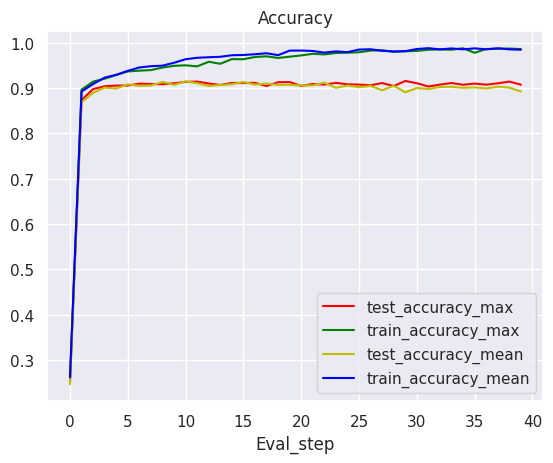

In [15]:
for (aggregation_type, color) in zip(["max", "mean"], [["r", "g"], ["y", "b"]]):
    plt.plot(np.arange(len(acc[aggregation_type])), acc[aggregation_type], color=color[0], label=f"test_accuracy_{aggregation_type}")
    plt.plot(np.arange(len(acc_train[aggregation_type])), acc_train[aggregation_type], color=color[1], label=f"train_accuracy_{aggregation_type}")

plt.title('Accuracy')
plt.xlabel("Eval_step")
plt.legend()
plt.show()

In [17]:
max(acc_train["max"]), max(acc_train["mean"]), max(acc["max"]), max(acc["mean"])

(0.9881999492645264,
 0.9883999824523926,
 0.9159999489784241,
 0.9151999950408936)

## Вывод

    Выводы по каждому эксперименту:
    1) Как мы можем увидеть, GRU модель дает прирост качества, однако, она склона к переобучению. 
    2) Увеличение числа скрытых слоев в базовой модели в совокупности с увеличением p(drop out) позволяют снизить переобучение, однако не влияют на тестовый accuracy
    3) Прирост качества в совокупности с уменьшением переобучения дает модель GRU + hidden_dim=512 + p = 0.25(drop out) на 10 эпохах. Качество 0.916, 0.9152 на max и min агрегации соответственно
    
    Колебания качества на всех моделях не существенны. На 10 эпохах качество на каждой модели сходится. Лучшая модель - GRU + hidden_dim=512 + p = 0.25(drop out) + max agr на 10 эпохах, с точностью 0.916.